BERT Contrastive Learning - Normal Training
This will attempt to train with batch_size=2048 and OOM on T4
=== Normal Contrastive Training (Will OOM) ===
Using device: cuda
Creating 2048 question-passage pairs...
Tokenizing 2048 examples...
Initial: 0.41 GB
Starting forward pass with batch size 2048...
After Q encode: 8.39 GB
At OOM: 14.21 GB
💥 OOM ERROR after 1.88s!
GPU memory at crash: 14.21 GB
This is expected! BERT with batch_size=2048 requires ~25GB+ memory
Use gradient_caching_fixed.py to train with this batch size.


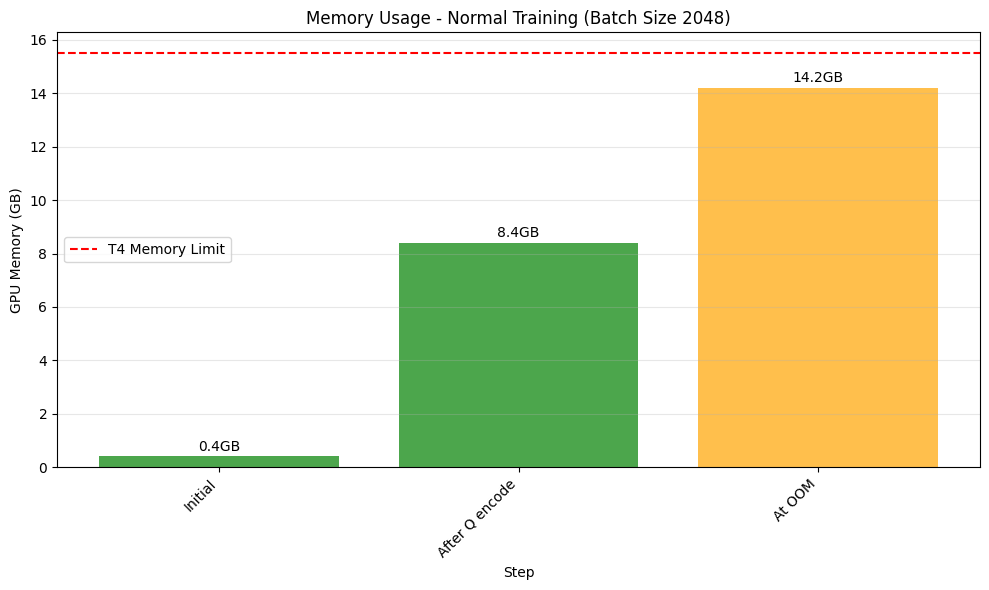

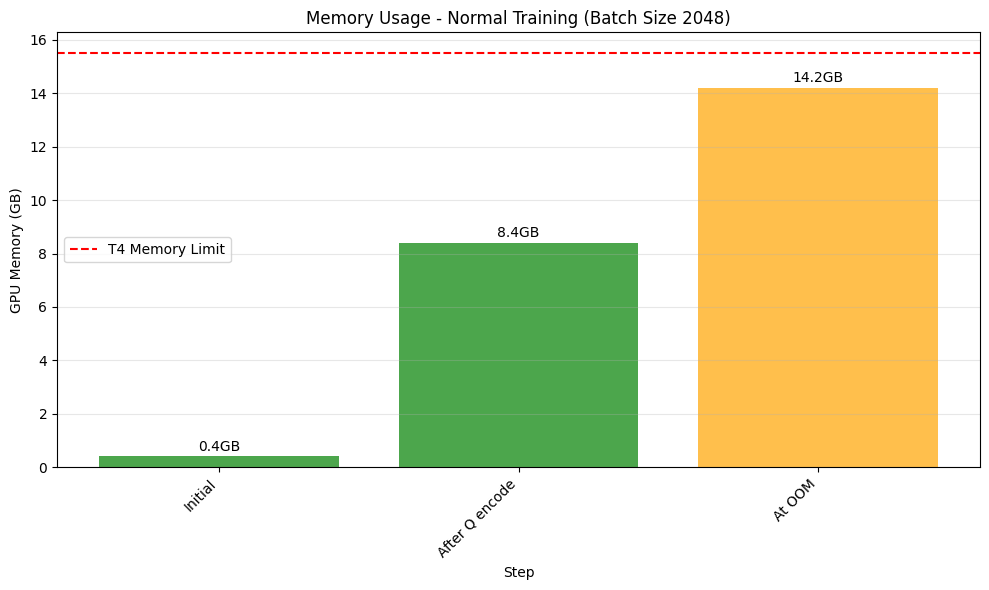

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer
import time
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

class BERTEncoder(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.projection = nn.Linear(768, 256)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state.mean(dim=1)
        projected = self.projection(pooled)
        return F.normalize(projected, p=2, dim=1)

def create_data(batch_size=2048):
    print(f"Creating {batch_size} question-passage pairs...")
    base_questions = ["what causes rain", "how do airplanes fly", "why is the sky blue", "what is machine learning", "how does wifi work", "what causes earthquakes", "how do vaccines work", "what is quantum computing"]
    base_passages = ["rain is caused by water vapor condensing in clouds", "airplanes fly using lift generated by wing shape", "sky appears blue due to light scattering", "machine learning is algorithms learning from data", "wifi uses radio waves to transmit data", "earthquakes caused by tectonic plate movement", "vaccines train immune system against diseases", "quantum computing uses quantum mechanics principles"]
    questions = base_questions * (batch_size // 8 + 1)
    passages = base_passages * (batch_size // 8 + 1)
    return questions[:batch_size], passages[:batch_size]

def plot_memory_usage(memory_points, labels, title):
    plt.figure(figsize=(10, 6))
    x = range(len(memory_points))
    colors = ['green' if m < 14 else 'orange' if m < 15.5 else 'red' for m in memory_points]
    bars = plt.bar(x, memory_points, color=colors, alpha=0.7)
    plt.axhline(y=15.5, color='red', linestyle='--', label='T4 Memory Limit')
    plt.xlabel('Step')
    plt.ylabel('GPU Memory (GB)')
    plt.title(title)
    plt.xticks(x, labels, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    for i, (bar, mem) in enumerate(zip(bars, memory_points)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{mem:.1f}GB', ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('memory_usage_oom.png', dpi=150)
    plt.show()

def normal_training_that_ooms():
    print("=== Normal Contrastive Training (Will OOM) ===")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    if device.type == 'cpu':
        print("WARNING: Running on CPU, won't demonstrate OOM")
        batch_size = 32
    else:
        batch_size = 2048
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    encoder = BERTEncoder().to(device)
    questions, passages = create_data(batch_size)
    print(f"Tokenizing {batch_size} examples...")
    q_tokens = tokenizer(questions, padding=True, truncation=True, max_length=64, return_tensors='pt').to(device)
    p_tokens = tokenizer(passages, padding=True, truncation=True, max_length=64, return_tensors='pt').to(device)
    memory_points = []
    labels = []

    def track_memory(label):
        if torch.cuda.is_available():
            mem = torch.cuda.memory_allocated()/1024**3
            memory_points.append(mem)
            labels.append(label)
            print(f"{label}: {mem:.2f} GB")

    track_memory("Initial")
    optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-5)
    print(f"Starting forward pass with batch size {batch_size}...")
    start_time = time.time()

    try:
        q_embeds = encoder(q_tokens['input_ids'], q_tokens['attention_mask'])
        track_memory("After Q encode")
        p_embeds = encoder(p_tokens['input_ids'], p_tokens['attention_mask'])
        track_memory("After P encode")
        similarities = torch.mm(q_embeds, p_embeds.t()) / 0.1
        track_memory("After similarity")
        labels_tensor = torch.arange(batch_size, device=device)
        loss = F.cross_entropy(similarities, labels_tensor)
        print(f"Loss: {loss.item():.4f}")
        print("Starting backward pass (this is where OOM happens)...")
        loss.backward()
        track_memory("After backward")
        optimizer.step()
        track_memory("After optimize")
        print(f"Training completed! Time: {time.time() - start_time:.2f}s")
        print(f"Final GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
    except RuntimeError as e:
        if "out of memory" in str(e):
            track_memory("At OOM")
            print(f"💥 OOM ERROR after {time.time() - start_time:.2f}s!")
            print(f"GPU memory at crash: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
            print(f"This is expected! BERT with batch_size={batch_size} requires ~25GB+ memory")
            print("Use gradient_caching_fixed.py to train with this batch size.")
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            plot_memory_usage(memory_points, labels, f'Memory Usage - Normal Training (Batch Size {batch_size})')
        else:
            raise e
    if len(memory_points) > 0:
        plot_memory_usage(memory_points, labels, f'Memory Usage - Normal Training (Batch Size {batch_size})')

if __name__ == "__main__":
    print("BERT Contrastive Learning - Normal Training")
    print("This will attempt to train with batch_size=2048 and OOM on T4")
    normal_training_that_ooms()